# Valuación de opciones usando simulación

## 1. Motivación e introducción
En la clase pasada vimos el uso de la volatilidad (desviación estándar de los rendimientos) para valuar opciones. Asímismo, vimos como dado el valor de la opción podíamos calcular la volatilidad implícita por el método de valuación libre de riesgo.

Sin embargo, también vimos hace un par de clases que los rendimientos diarios no son generalmente un p.e. estacionario, así que suponerlos estacionarios como tal es caer en una falacia.

Importemos las librerías necesarias:

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

Con lo que hemos aprendido, deberíamos ser capaces de crear una función que nos devuelva un `DataFrame` de `pandas` con los precios de cierre ajustados de ciertas compañías en ciertas fechas:
- Escribir la función a continuación

In [3]:
def get_historical_closes(ticker, start_date, end_date=None):
    closes = web.DataReader(name=ticker, data_source='yahoo', start=start_date, end=end_date).sort_index('major_axis')
    return closes.loc['Adj Close',:]

- Obtener como ejemplo los precios de cierre de Apple del año pasado hasta la fecha. Graficar...

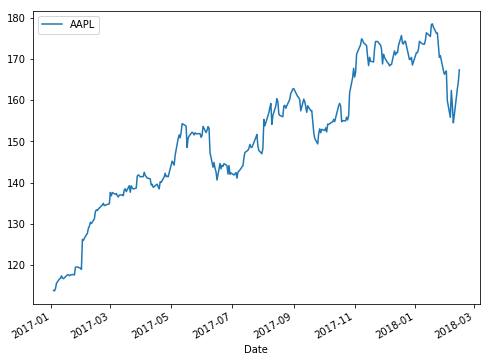

In [4]:
closes_aapl = get_historical_closes(['AAPL'], '2017-01-01')
closes_aapl.plot(figsize=(8,6));

- Escribir una función que pasándole el histórico de precios devuelva los rendimientos logarítmicos:

In [5]:
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

- Graficar...

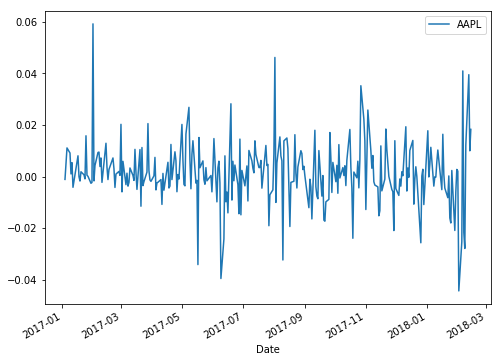

In [6]:
ret_aapl = calc_daily_ret(closes_aapl)
ret_aapl.plot(figsize=(8,6));

También, descargar datos de opciones de Apple:

In [7]:
opt_aapl = web.Options('AAPL', 'yahoo').get_all_data().reset_index()
opt_aapl

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
0,2.5,2018-02-16,call,...,2018-02-14 21:00:02,2018-02-14 20:52:20,"{'contractSymbol': 'AAPL180216C00002500', 'str..."
1,2.5,2018-02-16,put,...,2018-02-14 21:00:02,2018-01-20 04:44:39,"{'contractSymbol': 'AAPL180216P00002500', 'str..."
2,2.5,2018-04-20,call,...,2018-02-14 21:00:02,2017-11-28 16:24:01,"{'contractSymbol': 'AAPL180420C00002500', 'str..."
3,2.5,2018-04-20,put,...,2018-02-14 21:00:02,2017-09-23 03:55:28,"{'contractSymbol': 'AAPL180420P00002500', 'str..."
4,5.0,2018-02-16,call,...,2018-02-14 21:00:02,2018-02-14 22:27:10,"{'contractSymbol': 'AAPL180216C00005000', 'str..."
...,...,...,...,...,...,...,...
920,310.0,2018-04-20,call,...,2018-02-14 21:00:02,2018-02-12 15:45:31,"{'contractSymbol': 'AAPL180420C00310000', 'str..."
921,315.0,2018-04-20,put,...,2018-02-14 21:00:02,2018-02-12 17:56:03,"{'contractSymbol': 'AAPL180420P00315000', 'str..."
922,320.0,2018-04-20,call,...,2018-02-14 21:00:02,2018-02-07 14:32:34,"{'contractSymbol': 'AAPL180420C00320000', 'str..."
923,345.0,2018-02-16,call,...,2018-02-14 21:00:02,2018-01-24 14:35:46,"{'contractSymbol': 'AAPL180216C00345000', 'str..."


In [8]:
opt_aapl.loc[(opt_aapl.Expiry=='2018-06-15') & (opt_aapl.Type=='call') & (opt_aapl.Strike==180)]

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
621,180.0,2018-06-15,call,...,2018-02-14 21:00:02,2018-02-14 20:56:00,"{'contractSymbol': 'AAPL180615C00180000', 'str..."


In [9]:
opt_aapl.JSON[621]

{'ask': 4.45,
 'bid': 4.3,
 'change': 0.5999999,
 'contractSize': 'REGULAR',
 'contractSymbol': 'AAPL180615C00180000',
 'currency': 'USD',
 'expiration': 1529020800,
 'impliedVolatility': 0.2362136926269531,
 'inTheMoney': False,
 'lastPrice': 4.45,
 'lastTradeDate': 1518641760,
 'openInterest': 27002,
 'percentChange': 15.584414,
 'strike': 180.0,
 'volume': 2664}

## 2. Valuación usando simulación: modelo normal para los rendimientos

Comenzaremos por suponer que los rendimientos son un p.e. estacionario que distribuyen $\mathcal{N}(\mu,\sigma)$.

- Hallar media y desviación estándar muestral de los rendimientos

In [10]:
mu = ret_aapl.mean().AAPL
sigma = ret_aapl.std().AAPL
mu, sigma

(0.0013713391250428425, 0.011998203737520759)

No se toma la media sino la tasa libre de riesgo

In [11]:
r = 0.0160/360

- Simularemos el tiempo de contrato (días=123), 10 escenarios:
    - Generar fechas

In [12]:
ndays = 121
nscen = 10
dates = pd.date_range('2018-02-15', periods = ndays)
dates

DatetimeIndex(['2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18',
               '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22',
               '2018-02-23', '2018-02-24',
               ...
               '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09',
               '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13',
               '2018-06-14', '2018-06-15'],
              dtype='datetime64[ns]', length=121, freq='D')

- Generamos 10 escenarios de rendimientos simulados y guardamos en un dataframe

In [13]:
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r, index=dates)
sim_ret

,0,1,2,...,7,8,9
2018-02-15,-4.736e-04,1.783e-04,1.181e-02,...,-0.005,-2.891e-03,0.019
2018-02-16,-9.766e-03,-6.188e-03,-1.115e-02,...,-0.014,-1.111e-03,-0.011
2018-02-17,1.554e-02,1.054e-02,-1.474e-02,...,-0.011,-3.245e-03,0.005
2018-02-18,-5.917e-03,1.729e-02,2.182e-02,...,0.002,-1.235e-04,-0.012
2018-02-19,2.486e-02,8.285e-03,-3.813e-05,...,0.007,1.523e-02,0.033
...,...,...,...,...,...,...,...
2018-06-11,5.838e-03,-1.213e-02,1.904e-02,...,0.009,-5.020e-03,0.012
2018-06-12,-3.367e-04,7.097e-03,-1.664e-02,...,-0.033,-1.157e-02,0.014
2018-06-13,-5.650e-03,8.040e-03,-3.111e-03,...,-0.002,-2.165e-02,-0.026
2018-06-14,-1.047e-03,-1.109e-02,-1.045e-03,...,-0.011,7.970e-03,0.008


- Con los rendimientos simulados, calcular los escenarios de precios respectivos:

In [14]:
sim_closes = closes_aapl.iloc[-1].AAPL*np.exp(sim_ret.cumsum())
sim_closes

,0,1,2,...,7,8,9
2018-02-15,167.291,167.400,169.358,...,166.512,166.887,170.549
2018-02-16,165.665,166.367,167.481,...,164.235,166.702,168.710
2018-02-17,168.260,168.129,165.031,...,162.471,166.162,169.555
2018-02-18,167.267,171.061,168.672,...,162.868,166.141,167.566
2018-02-19,171.478,172.484,168.666,...,164.032,168.691,173.253
...,...,...,...,...,...,...,...
2018-06-11,194.362,172.680,192.371,...,180.476,123.065,167.877
2018-06-12,194.296,173.910,189.197,...,174.562,121.649,170.186
2018-06-13,193.202,175.314,188.609,...,174.242,119.044,165.798
2018-06-14,193.000,173.380,188.412,...,172.354,119.996,167.099


- Graficar:

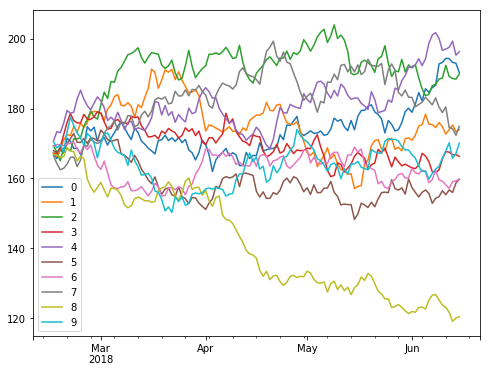

In [15]:
sim_closes.plot(figsize=(8,6));

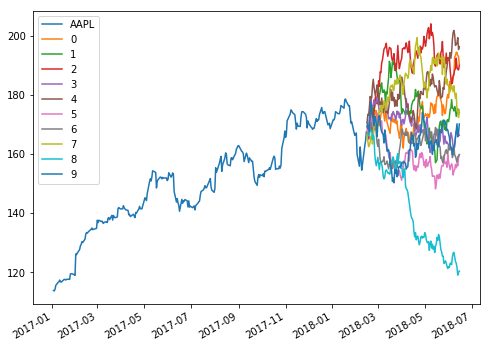

In [16]:
pd.concat([closes_aapl,sim_closes]).plot(figsize=(8,6));

In [17]:
K=180
ndays = 121
nscen = 100000
dates = pd.date_range('2018-02-15',periods=ndays)
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret.cumsum())
#strike = pd.DataFrame({'Strike':K*np.ones(ndays)}, index=dates)
#simul = pd.concat([closes_aapl.T,strike.T,sim_closes.T]).T
#simul.plot(figsize=(8,6),legend=False);

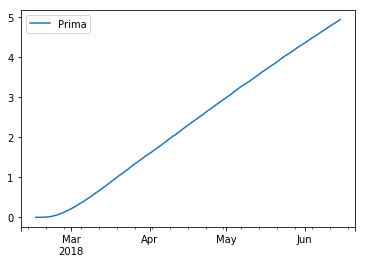

In [18]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)),index=dates)
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()},index=dates)
call.plot();

La valuación de la opción es:

In [19]:
call.iloc[-1]

Prima    4.946
Name: 2018-06-15 00:00:00, dtype: float64

Intervalo de confianza del 95%

In [40]:
sigma_est = sim_closes.iloc[-1].std()
(call.iloc[-1].Prima-1.96*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen),call.iloc[-1].Prima+1.96*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen))

(4.8536506208784118, 5.1311533308975221)

## 3. Valuación usando simulación: uso del histograma de rendimientos

Todo el análisis anterior se mantiene. Solo cambia la forma de generar los números aleatorios para la simulación montecarlo.

Ahora, generemos un histograma de los rendimientos diarios para generar valores aleatorios de los rendimientos simulados.

- Primero, cantidad de días y número de escenarios de simulación

In [46]:
ndays = 121
nscen = 10

- Generamos el histograma y obtenemos las probabilidades de ocurrencia

In [47]:
freq, values = np.histogram(ret_aapl-mu+r, bins=250)
prob = freq/np.sum(freq)

- Con esto, generamos los números aleatorios correspondientes a los rendimientos (tantos como días por número de escenarios).

In [48]:
ret = np.random.choice(values[1:], ndays*nscen, p=prob)
dates = pd.date_range('2018-02-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_ret_hist

,0,1,2,...,7,8,9
2018-02-15,7.333e-03,6.090e-03,-0.015,...,4.847e-03,-5.373e-04,-3.437e-03
2018-02-16,-5.373e-04,9.818e-03,0.009,...,-1.231e-04,-5.373e-04,-1.780e-03
2018-02-17,7.747e-03,-2.498e-02,-0.022,...,-1.231e-04,-3.437e-03,-6.336e-03
2018-02-18,-1.048e-02,9.404e-03,-0.009,...,-9.516e-04,-3.851e-03,-6.751e-03
2018-02-19,1.396e-02,-9.516e-04,0.009,...,-5.373e-04,1.396e-02,-5.373e-04
...,...,...,...,...,...,...,...
2018-06-11,-5.508e-03,-6.336e-03,0.005,...,6.918e-03,-1.255e-02,1.934e-02
2018-06-12,-1.366e-03,-7.579e-03,-0.005,...,-3.023e-03,4.847e-03,-2.194e-03
2018-06-13,1.272e-02,-4.679e-03,0.002,...,9.404e-03,2.776e-03,1.948e-03
2018-06-14,1.023e-02,8.575e-03,-0.006,...,3.840e-02,-3.023e-03,-8.822e-03


Escenarios de precios respectivos

In [49]:
sim_closes_hist = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_hist.cumsum())
sim_closes_hist

,0,1,2,...,7,8,9
2018-02-15,168.602,168.392,164.804,...,168.183,167.280,166.796
2018-02-16,168.511,170.054,166.361,...,168.163,167.190,166.499
2018-02-17,169.822,165.859,162.729,...,168.142,166.617,165.447
2018-02-18,168.052,167.426,161.233,...,167.982,165.976,164.334
2018-02-19,170.414,167.267,162.756,...,167.892,168.309,164.246
...,...,...,...,...,...,...,...
2018-06-11,198.040,166.073,175.261,...,176.939,173.025,170.605
2018-06-12,197.770,164.819,174.443,...,176.405,173.866,170.231
2018-06-13,200.301,164.050,174.711,...,178.071,174.349,170.563
2018-06-14,202.361,165.463,173.751,...,185.042,173.823,169.065


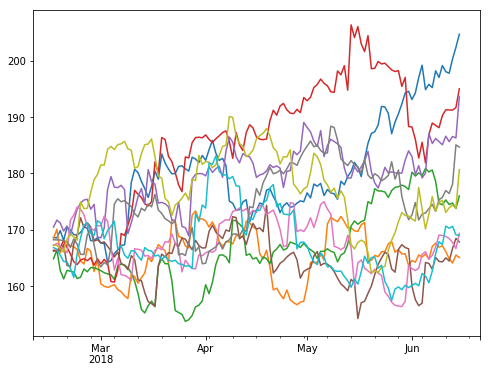

In [50]:
sim_closes_hist.plot(figsize=(8,6),legend=False);

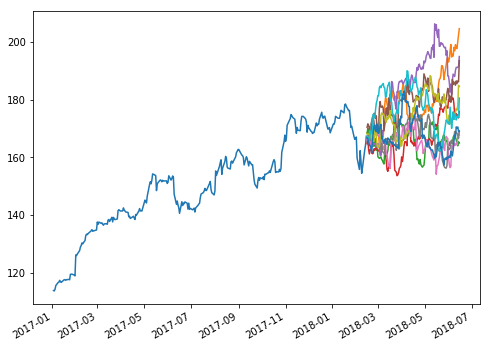

In [51]:
pd.concat([closes_aapl,sim_closes_hist]).plot(figsize=(8,6),legend=False);

In [52]:
K=180
ndays = 121
nscen = 100000
freq, values = np.histogram(ret_aapl-mu+r, bins=250)
prob = freq/np.sum(freq)
ret=np.random.choice(values[1:],ndays*nscen,p=prob)
dates=pd.date_range('2018-02-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_hist.cumsum())
#strike = pd.DataFrame({'Strike':K*np.ones(ndays)}, index=dates)
#simul_hist = pd.concat([closes_aapl.T,strike.T,sim_closes_hist.T]).T
#simul_hist.plot(figsize=(8,6), legend=False);

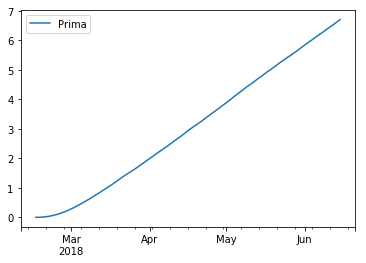

In [53]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
call_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
call_hist.plot();

In [54]:
call_hist.iloc[-1]

Prima    6.7
Name: 2018-06-15 00:00:00, dtype: float64

Intervalo de confianza del 95%

In [55]:
sigma_est = sim_closes_hist.iloc[-1].std()
(call_hist.iloc[-1].Prima-4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen),call_hist.iloc[-1].Prima+4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen))

(6.3720040417148063, 7.0272298383886174)

## 4. Valuación usando simulación: uso de la distrubición empírica aproximada con un método de kernel

- Primero estimamos la densidad de los rendimientos con kernel gaussiano

In [59]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(ret_aapl-mu+r)

- Días y número de escenarios

In [60]:
ndays = 121
nscen = 10

- Generamos los rendimientos simulados

In [61]:
ret = kde.sample(n_samples=ndays*nscen, random_state=None)
dates = pd.date_range('2018-02-15', periods=ndays)
sim_ret_kernel = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_ret_kernel

,0,1,2,...,7,8,9
2018-02-15,-7.112e-04,-0.035,0.009,...,-0.013,-4.589e-03,5.787e-04
2018-02-16,6.066e-03,0.007,-0.003,...,0.010,5.881e-03,8.592e-03
2018-02-17,2.627e-02,-0.007,0.044,...,-0.015,6.864e-03,3.359e-03
2018-02-18,-6.227e-04,-0.026,-0.010,...,0.011,4.149e-03,-2.094e-03
2018-02-19,-3.551e-02,0.017,-0.002,...,-0.004,1.137e-02,-4.994e-03
...,...,...,...,...,...,...,...
2018-06-11,1.650e-02,-0.007,-0.007,...,-0.017,-4.454e-02,2.102e-02
2018-06-12,2.038e-03,-0.004,-0.004,...,-0.012,-2.344e-02,-5.541e-03
2018-06-13,-7.971e-03,-0.010,-0.002,...,-0.007,2.122e-04,7.173e-03
2018-06-14,-1.911e-02,-0.007,-0.005,...,0.005,6.645e-03,-2.002e-02


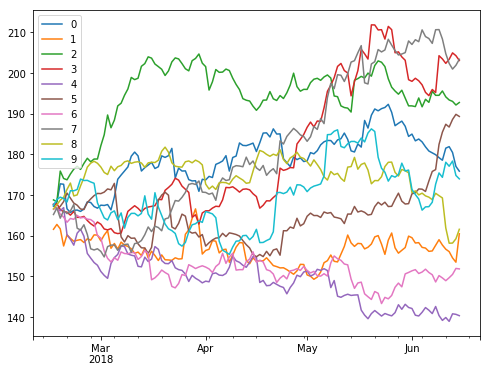

In [62]:
sim_closes_kernel = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_kernel.cumsum())
sim_closes_kernel.plot(figsize=(8,6));

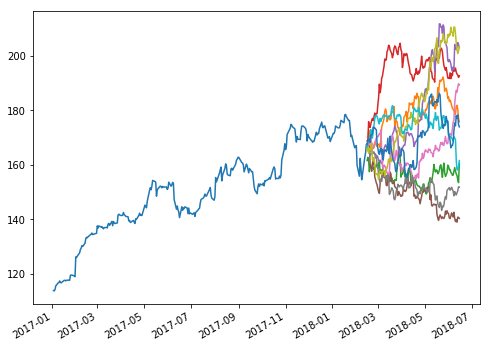

In [63]:
pd.concat([closes_aapl,sim_closes_kernel]).plot(figsize=(8,6),legend=False);

In [64]:
K=180
ndays = 121
nscen = 100000
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(ret_aapl-mu+r)
ret = kde.sample(n_samples=ndays*nscen, random_state=None)
dates = pd.date_range('2018-02-15', periods=ndays)
sim_ret_kernel = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_kernel = (closes_aapl.iloc[-1].AAPL)*np.exp(sim_ret_kernel.cumsum())
#strike = pd.DataFrame({'Strike':K*np.ones(ndays)}, index=dates)
#simul_hist = pd.concat([closes_aapl.T,strike.T,sim_closes_hist.T]).T
#simul_hist.plot(figsize=(8,6), legend=False);

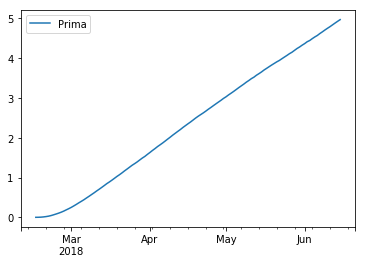

In [65]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
call_kernel = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_kernel-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
call_kernel.plot();

In [66]:
call_kernel.iloc[-1]

Prima    4.969
Name: 2018-06-15 00:00:00, dtype: float64

Intervalo de confianza del 95%

In [67]:
sigma_est = sim_closes_kernel.iloc[-1].std()
(call_kernel.iloc[-1].Prima-4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen),call_kernel.iloc[-1].Prima+4.5*sigma_est*np.exp(-r*ndays)/np.sqrt(nscen))

(4.6489597482624125, 5.2891209974318949)

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>